Since predicting solely whether customers will tip or not may discourage drivers from picking up customers who are predicted not to tip, I will build a model that predicts **generous customers (those whose tips are ≥ 20%).**

**Features** needed to make this prediction:

    -The dataset already includes the tip amount and the cost of the ride; I will use these to engineer a new column ('generous' column) and make this the target variable.

    -Time, date, pickup and dropoff locations, estimated fare, and payment method.

In [ ]:
##### Preparing Data

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

In [3]:
# Load dataset into dataframe
df0 = pd.read_csv('2017_Yellow_Taxi_Trip_Data.csv')

# Import predicted fares and mean distance and duration from previous course
nyc_preds_means = pd.read_csv('nyc_preds_means.csv')

In [4]:
print(df0.head())

   Unnamed: 0  VendorID    tpep_pickup_datetime   tpep_dropoff_datetime  \
0    24870114         2   03/25/2017 8:55:43 AM   03/25/2017 9:09:47 AM   
1    35634249         1   04/11/2017 2:53:28 PM   04/11/2017 3:19:58 PM   
2   106203690         1   12/15/2017 7:26:56 AM   12/15/2017 7:34:08 AM   
3    38942136         2   05/07/2017 1:17:59 PM   05/07/2017 1:48:14 PM   
4    30841670         2  04/15/2017 11:32:20 PM  04/15/2017 11:49:03 PM   

   passenger_count  trip_distance  RatecodeID store_and_fwd_flag  \
0                6           3.34           1                  N   
1                1           1.80           1                  N   
2                1           1.00           1                  N   
3                1           3.70           1                  N   
4                1           4.37           1                  N   

   PULocationID  DOLocationID  payment_type  fare_amount  extra  mta_tax  \
0           100           231             1         13.0    0.0 

In [5]:
print(nyc_preds_means.head())

   mean_duration  mean_distance  predicted_fare
0      22.847222       3.521667       16.434245
1      24.470370       3.108889       16.052218
2       7.250000       0.881429        7.053706
3      30.250000       3.700000       18.731650
4      14.616667       4.435000       15.845642


In [6]:
df = pd.merge(nyc_preds_means, df0, left_index=True, right_index=True)
print(df)

       mean_duration  mean_distance  predicted_fare  Unnamed: 0  VendorID  \
0          22.847222       3.521667       16.434245    24870114         2   
1          24.470370       3.108889       16.052218    35634249         1   
2           7.250000       0.881429        7.053706   106203690         1   
3          30.250000       3.700000       18.731650    38942136         2   
4          14.616667       4.435000       15.845642    30841670         2   
...              ...            ...             ...         ...       ...   
22694       8.594643       1.098214        7.799138    14873857         2   
22695      59.560417      18.757500       52.000000    66632549         2   
22696       6.609091       0.684242        6.130896    74239933         2   
22697      16.650000       2.077500       11.707049    60217333         2   
22698       9.405556       1.476970        8.600969    17208911         1   

         tpep_pickup_datetime   tpep_dropoff_datetime  passenger_count  \
0

In [7]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   mean_duration          22699 non-null  float64
 1   mean_distance          22699 non-null  float64
 2   predicted_fare         22699 non-null  float64
 3   Unnamed: 0             22699 non-null  int64  
 4   VendorID               22699 non-null  int64  
 5   tpep_pickup_datetime   22699 non-null  object 
 6   tpep_dropoff_datetime  22699 non-null  object 
 7   passenger_count        22699 non-null  int64  
 8   trip_distance          22699 non-null  float64
 9   RatecodeID             22699 non-null  int64  
 10  store_and_fwd_flag     22699 non-null  object 
 11  PULocationID           22699 non-null  int64  
 12  DOLocationID           22699 non-null  int64  
 13  payment_type           22699 non-null  int64  
 14  fare_amount            22699 non-null  float64
 15  ex

By doing EDA, I notice that customers who pay **cash** generally have a tip amount of $0. To meet the modeling objective, I will sample the data to select only the customers who pay with credit card. 

In [8]:
df1 = df0.copy()
mask = df1['payment_type'] == 1
df1 = df1[mask].reset_index(drop = True)
print(df1)

       Unnamed: 0  VendorID    tpep_pickup_datetime   tpep_dropoff_datetime  \
0        24870114         2   03/25/2017 8:55:43 AM   03/25/2017 9:09:47 AM   
1        35634249         1   04/11/2017 2:53:28 PM   04/11/2017 3:19:58 PM   
2       106203690         1   12/15/2017 7:26:56 AM   12/15/2017 7:34:08 AM   
3        38942136         2   05/07/2017 1:17:59 PM   05/07/2017 1:48:14 PM   
4        23345809         2   03/25/2017 8:34:11 PM   03/25/2017 8:42:11 PM   
...           ...       ...                     ...                     ...   
15260    60425673         1   07/16/2017 3:22:51 AM   07/16/2017 3:40:52 AM   
15261    67858616         2  08/10/2017 10:20:04 PM  08/10/2017 10:29:31 PM   
15262    66632549         2   08/06/2017 4:43:59 PM   08/06/2017 5:24:47 PM   
15263    60217333         2  07/15/2017 12:56:30 PM   07/15/2017 1:08:26 PM   
15264    17208911         1   03/02/2017 1:02:49 PM   03/02/2017 1:16:09 PM   

       passenger_count  trip_distance  RatecodeID s

In [10]:
# Create tip % col
import numpy as np
df1['tip%col'] = df1['tip_amount'] / (df1['total_amount'] - df1['tip_amount'])
df1['tip%col'] = np.ceil(df1['tip%col'] * 1000) / 1000
print(df1.head())

   Unnamed: 0  VendorID   tpep_pickup_datetime  tpep_dropoff_datetime  \
0    24870114         2  03/25/2017 8:55:43 AM  03/25/2017 9:09:47 AM   
1    35634249         1  04/11/2017 2:53:28 PM  04/11/2017 3:19:58 PM   
2   106203690         1  12/15/2017 7:26:56 AM  12/15/2017 7:34:08 AM   
3    38942136         2  05/07/2017 1:17:59 PM  05/07/2017 1:48:14 PM   
4    23345809         2  03/25/2017 8:34:11 PM  03/25/2017 8:42:11 PM   

   passenger_count  trip_distance  RatecodeID store_and_fwd_flag  \
0                6           3.34           1                  N   
1                1           1.80           1                  N   
2                1           1.00           1                  N   
3                1           3.70           1                  N   
4                6           2.30           1                  N   

   PULocationID  DOLocationID  payment_type  fare_amount  extra  mta_tax  \
0           100           231             1         13.0    0.0      0.5   


In [11]:
# Create 'generous' col (target)
df1['generous'] = df1['tip%col'].copy()
df1['generous'] = np.where(df1['generous'] >= 0.2, 1, 0)
print(df1['generous'])

0        1
1        1
2        0
3        1
4        1
        ..
15260    1
15261    1
15262    1
15263    0
15264    1
Name: generous, Length: 15265, dtype: int64


In [12]:
# Convert pickup and dropoff cols to datetime
df1['tpep_pickup_datetime'] = pd.to_datetime(df1['tpep_pickup_datetime'])
df1['tpep_dropoff_datetime'] = pd.to_datetime(df1['tpep_dropoff_datetime'])
print(df1.head())

   Unnamed: 0  VendorID tpep_pickup_datetime tpep_dropoff_datetime  \
0    24870114         2  2017-03-25 08:55:43   2017-03-25 09:09:47   
1    35634249         1  2017-04-11 14:53:28   2017-04-11 15:19:58   
2   106203690         1  2017-12-15 07:26:56   2017-12-15 07:34:08   
3    38942136         2  2017-05-07 13:17:59   2017-05-07 13:48:14   
4    23345809         2  2017-03-25 20:34:11   2017-03-25 20:42:11   

   passenger_count  trip_distance  RatecodeID store_and_fwd_flag  \
0                6           3.34           1                  N   
1                1           1.80           1                  N   
2                1           1.00           1                  N   
3                1           3.70           1                  N   
4                6           2.30           1                  N   

   PULocationID  DOLocationID  payment_type  fare_amount  extra  mta_tax  \
0           100           231             1         13.0    0.0      0.5   
1           186   

In [13]:
# Create a 'day' col
df1['day'] = df1['tpep_pickup_datetime'].dt.day_name().str.lower()
print(df1.head())

   Unnamed: 0  VendorID tpep_pickup_datetime tpep_dropoff_datetime  \
0    24870114         2  2017-03-25 08:55:43   2017-03-25 09:09:47   
1    35634249         1  2017-04-11 14:53:28   2017-04-11 15:19:58   
2   106203690         1  2017-12-15 07:26:56   2017-12-15 07:34:08   
3    38942136         2  2017-05-07 13:17:59   2017-05-07 13:48:14   
4    23345809         2  2017-03-25 20:34:11   2017-03-25 20:42:11   

   passenger_count  trip_distance  RatecodeID store_and_fwd_flag  \
0                6           3.34           1                  N   
1                1           1.80           1                  N   
2                1           1.00           1                  N   
3                1           3.70           1                  N   
4                6           2.30           1                  N   

   PULocationID  DOLocationID  payment_type  fare_amount  extra  mta_tax  \
0           100           231             1         13.0    0.0      0.5   
1           186   

#### Create time of day columns

In [14]:
# Create 'am_rush' col
df1['am_rush']  = df1['tpep_pickup_datetime'].copy().dt.time
# Create 'daytime' col
df1['daytime']  = df1['tpep_pickup_datetime'].copy().dt.time
# Create 'pm_rush' col
df1['pm_rush']  = df1['tpep_pickup_datetime'].copy().dt.time
# Create 'nighttime' col
df1['nighttime']  = df1['tpep_pickup_datetime'].copy().dt.time

In [15]:
# Define 'am_rush()' conversion function [06:00–10:00)
def am_rush(time):
    return 1 if time.hour >=6 and time.hour <10 else 0

In [16]:
# Apply 'am_rush' function to the 'am_rush' series
df1['am_rush'] = df1['am_rush'].apply(am_rush)
print(df1['am_rush'])

0        1
1        0
2        1
3        0
4        0
        ..
15260    0
15261    0
15262    0
15263    0
15264    0
Name: am_rush, Length: 15265, dtype: int64


In [17]:
# Define 'daytime()' conversion function [10:00–16:00)
def daytime(time):
    return 1 if time.hour >=10 and time.hour <16 else 0

In [18]:
# Apply 'daytime()' function to the 'daytime' series
df1['daytime'] = df1['daytime'].apply(daytime)
print(df1['daytime'])

0        0
1        1
2        0
3        1
4        0
        ..
15260    0
15261    0
15262    0
15263    1
15264    1
Name: daytime, Length: 15265, dtype: int64


In [19]:
# Define 'pm_rush()' conversion function [16:00–20:00)
def pm_rush(time):
    return 1 if time.hour >=16 and time.hour <20 else 0

In [20]:
# Apply 'pm_rush()' function to the 'pm_rush' series
df1['pm_rush'] = df1['pm_rush'].apply(pm_rush)
print(df1['pm_rush'])

0        0
1        0
2        0
3        0
4        0
        ..
15260    0
15261    0
15262    1
15263    0
15264    0
Name: pm_rush, Length: 15265, dtype: int64


In [21]:
# Define 'nighttime()' conversion function [20:00–06:00)
def nighttime(time):
    return 1 if time.hour >=20 or time.hour <6 else 0

In [22]:
# Apply 'nighttime' function to the 'nighttime' series
df1['nighttime'] = df1['nighttime'].apply(nighttime)
print(df1['nighttime'])

0        0
1        0
2        0
3        0
4        1
        ..
15260    1
15261    1
15262    0
15263    0
15264    0
Name: nighttime, Length: 15265, dtype: int64


#### Create `month` column

In [23]:
# Create 'month' col
df1['month'] = df1['tpep_pickup_datetime'].dt.strftime('%b')
print(df1['month'])

0        Mar
1        Apr
2        Dec
3        May
4        Mar
        ... 
15260    Jul
15261    Aug
15262    Aug
15263    Jul
15264    Mar
Name: month, Length: 15265, dtype: object


In [24]:
print(df1.head())

   Unnamed: 0  VendorID tpep_pickup_datetime tpep_dropoff_datetime  \
0    24870114         2  2017-03-25 08:55:43   2017-03-25 09:09:47   
1    35634249         1  2017-04-11 14:53:28   2017-04-11 15:19:58   
2   106203690         1  2017-12-15 07:26:56   2017-12-15 07:34:08   
3    38942136         2  2017-05-07 13:17:59   2017-05-07 13:48:14   
4    23345809         2  2017-03-25 20:34:11   2017-03-25 20:42:11   

   passenger_count  trip_distance  RatecodeID store_and_fwd_flag  \
0                6           3.34           1                  N   
1                1           1.80           1                  N   
2                1           1.00           1                  N   
3                1           3.70           1                  N   
4                6           2.30           1                  N   

   PULocationID  DOLocationID  payment_type  fare_amount  extra  mta_tax  \
0           100           231             1         13.0    0.0      0.5   
1           186   

In [25]:
# Drop columns
print(df1.columns.tolist())
column_to_drop = ['Unnamed: 0', 'VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 
                  'trip_distance', 'store_and_fwd_flag','payment_type', 'fare_amount', 
                  'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 
                  'improvement_surcharge', 'total_amount', 'tip%col']
df1 = df1.drop(column_to_drop, axis = 'columns')
print(df1.head())

['Unnamed: 0', 'VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'tip%col', 'generous', 'day', 'am_rush', 'daytime', 'pm_rush', 'nighttime', 'month']
   RatecodeID  PULocationID  DOLocationID  generous       day  am_rush  \
0           1           100           231         1  saturday        1   
1           1           186            43         1   tuesday        0   
2           1           262           236         0    friday        1   
3           1           188            97         1    sunday        0   
4           1           161           236         1  saturday        0   

   daytime  pm_rush  nighttime month  
0        0        0          0   Mar  
1        1        0          0   Apr  
2        0        0          0   Dec  
3        1  

#### Variable encoding

In [26]:
# 1. Define list of cols to convert to string
cols_to_str = ['RatecodeID','PULocationID', 'DOLocationID']
# 2. Convert each column to string
for i in cols_to_str:
    df1[i] = df[i].astype(str)
print(df1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15265 entries, 0 to 15264
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   RatecodeID    15265 non-null  object
 1   PULocationID  15265 non-null  object
 2   DOLocationID  15265 non-null  object
 3   generous      15265 non-null  int64 
 4   day           15265 non-null  object
 5   am_rush       15265 non-null  int64 
 6   daytime       15265 non-null  int64 
 7   pm_rush       15265 non-null  int64 
 8   nighttime     15265 non-null  int64 
 9   month         15265 non-null  object
dtypes: int64(5), object(5)
memory usage: 1.2+ MB
None


In [27]:
# Convert categoricals to binary
df2 = pd.get_dummies(df1)
print(df2.head())

   generous  am_rush  daytime  pm_rush  nighttime  RatecodeID_1  RatecodeID_2  \
0         1        1        0        0          0          True         False   
1         1        0        1        0          0          True         False   
2         0        1        0        0          0          True         False   
3         1        0        1        0          0          True         False   
4         1        0        0        0          1          True         False   

   RatecodeID_3  RatecodeID_4  RatecodeID_5  RatecodeID_99  PULocationID_1  \
0         False         False         False          False           False   
1         False         False         False          False           False   
2         False         False         False          False           False   
3         False         False         False          False           False   
4         False         False         False          False           False   

   PULocationID_10  PULocationID_100  PULoca

##### Evaluation metric

In [28]:
# Get class balance of 'generous' col
print(df2['generous'].value_counts())

generous
1    9284
0    5981
Name: count, dtype: int64


A little over half of the customers in this dataset were "generous" (tipped ≥ 20%). The dataset is very nearly balanced.

**False positives and False negatives** are equally costly as:

    -False positives are worse for cab drivers, because they would pick up a customer expecting a good tip and then not receive one, frustrating the driver.

    -False negatives are worse for customers, because a cab driver would likely pick up a different customer who was predicted to tip more&mdash;even when the original customer would have tipped generously.

**Therefore, F1 score is chosen; the metric will weigh both precision and recall equally**

In [29]:
x = df2.drop('generous', axis = 'columns')
y = df2['generous']
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [ ]:
#####Tree Forest

In [30]:
# 1. Instantiate the random forest classifier
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state = 42)
# 2. Create a dictionary of hyperparameters to tune 
cv_params = {
    'max_depth': [None, 10, 20],
    'max_features': ['sqrt', 'log2'],
    'max_samples': [None],
    'min_samples_leaf': [1],
    'min_samples_split': [2, 5],
    'n_estimators': [100, 200]
}
# 3. Define a list of scoring metrics to capture
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}
# 4. Instantiate the GridSearchCV object
from sklearn.model_selection import GridSearchCV
rf1 = GridSearchCV(
    estimator = rf,
    param_grid = cv_params,
    scoring = scoring,
    cv = 5,
    refit = 'f1'
)


In [31]:
# rf1.fit(x_train, y_train)

In [32]:
import pickle
path = '/home/jovyan/work/model.pickle'
with open(path, 'wb') as f:
    pickle.dump(rf1, f)

In [33]:
def write_pickle(path, model_object, save_name:str):
    with open(path + save_name + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)

In [34]:
def read_pickle(path, saved_model_name:str):
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

        return model

In [35]:
with open('/home/jovyan/work/model.pkl', 'rb') as to_read:
    rf1 = pickle.load(to_read)
print(rf1.best_score_)

0.7578903743779539


In [36]:
print(rf1.best_params_)

{'max_depth': 20, 'max_features': 'log2', 'max_samples': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [37]:
def make_results(model_name:str, model_object, metric:str):
    metric_dict = {'precision': 'mean_test_precision',
                 'recall': 'mean_test_recall',
                 'f1': 'mean_test_f1',
                 'accuracy': 'mean_test_accuracy',
                 }

    cv_results = pd.DataFrame(model_object.cv_results_)
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
    table = pd.DataFrame({'model': [model_name],
                        'precision': [precision],
                        'recall': [recall],
                        'F1': [f1],
                        'accuracy': [accuracy],
                        },
                       )

    return table

In [38]:
#==> ENTER YOUR CODE HERE
print(make_results('Model_1', rf1, 'f1'))

     model  precision   recall       F1  accuracy
0  Model_1   0.610514  0.99906  0.75789  0.610547


In [39]:
rf_preds = rf1.best_estimator_.predict(x_test)
print(rf_preds)

[1 1 1 ... 1 1 1]


In [40]:
def get_test_scores(model_name:str, preds, y_test_data):
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                        'precision': [precision],
                        'recall': [recall],
                        'F1': [f1],
                        'accuracy': [accuracy]
                        })

    return table

In [41]:
rf_test_scores = get_test_scores('Model_1', rf_preds, y_test)
print(rf_test_scores)

     model  precision    recall        F1  accuracy
0  Model_1        0.6  0.998363  0.749539   0.59941


In [47]:
# 1. Instantiate the XGBoost classifier
import xgboost as xgb 
xgb = xgb.XGBClassifier(objective='binary:logistic', random_state =42)
# 2. Create a dictionary of hyperparameters to tune
cv_params = {
    'max_depth': [None, 10, 20],
    'min_child_weight': [1, 2],
    'learning_rate': [0.1, 0.2, 0.3],
    'n_estimators': [100, 200]
}

# 3. Define a list of scoring metrics to capture
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}
# 4. Instantiate the GridSearchCV object
from sklearn.model_selection import GridSearchCV
xgb1 = GridSearchCV(
    estimator = xgb,
    param_grid = cv_params,
    scoring = scoring,
    cv = 4,
    refit = 'f1'
)


In [48]:
xgb1.fit(x_train, y_train)
import pickle
path = '/home/jovyan/work/model_xgb.pickle'
with open(path, 'wb') as f:
    pickle.dump(xgb1, f)

CPU times: user 4min 8s, sys: 3.14 s, total: 4min 12s
Wall time: 2min 21s


In [49]:
with open('/home/jovyan/work/model_xgb.pickle', 'rb') as to_read:
    xgb1 = pickle.load(to_read)
print(xgb1.best_score_)

0.7496216824279349


In [50]:
print(xgb1.best_params_)

{'learning_rate': 0.1, 'max_depth': None, 'min_child_weight': 1, 'n_estimators': 100}


##### XGB

In [51]:
print(make_results('Model_xgb', xgb1, 'f1'))

       model  precision    recall        F1  accuracy
0  Model_xgb   0.612206  0.966581  0.749622  0.606043


In [52]:
xgb_preds = xgb1.best_estimator_.predict(x_test)
print(xgb_preds)

[1 1 1 ... 1 1 1]


In [53]:
xgb_test_scores = get_test_scores('Model_XGB', xgb_preds, y_test)
print(xgb_test_scores)

       model  precision    recall        F1  accuracy
0  Model_XGB   0.597161  0.963993  0.737479  0.587946


In [ ]:
##### Visualization

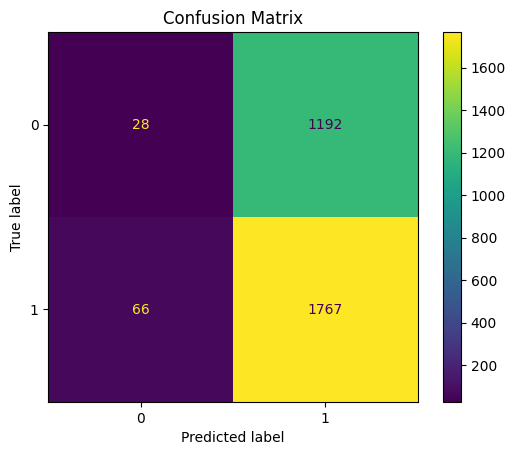

In [61]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, xgb_preds)
import matplotlib.pyplot as plt
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm)
cm_display.plot() 
plt.title("Confusion Matrix")
plt.show()

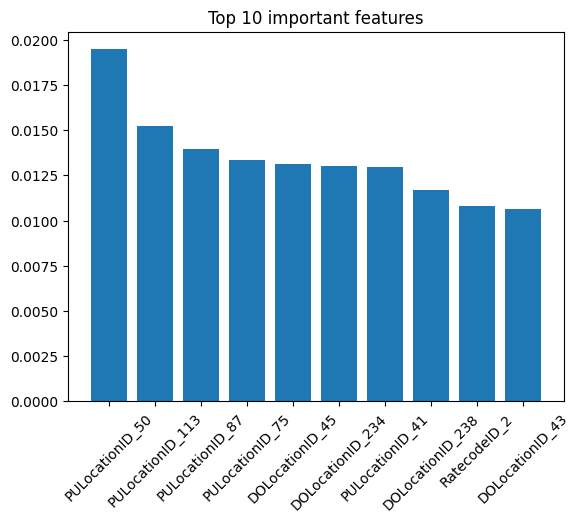

In [70]:
xgb1_importance = xgb1.best_estimator_.feature_importances_
import numpy as np
indices = np.argsort(xgb1_importance)[::-1]
plt.title('Top 10 important features')
plt.bar(range(10), xgb1_importance[indices[:10]], align = 'center')
plt.xticks(range(10), [x_train.columns[i] for i in indices[:10]], rotation = 45)
plt.show()

### **Conclusion**

1. **Are there new features that you can engineer that might improve model performance?**   

    -  New features can be engineered: trip distance (such as: short/ medium/ far). We could also engineer a column that gives a ratio that represents (the amount of money from the fare amount to the nearest higher multiple of \\$5) / fare amount. For example, if the fare were \\$12, the value in this column would be 0.25, because \\$12 to the nearest higher multiple of \\$5 (\\$15) is \\$3, and \\$3 divided by \\$12 is 0.25. The intuition for this feature is that people might be likely to simply round up their tip, so journeys with fares with values just under a multiple of \\$5 may have lower tip percentages than those with fare values just over a multiple of \\$5. We could also do the same thing for fares to the nearest \\$10.
    
2. **What features would you want to have that would likely improve the performance of your model?**   

It would probably be very helpful to have past tipping behavior for each customer. It would also be valuable to have accurate tip values for customers who pay with cash.
It would be helpful to have a lot more data. With enough data, we could create a unique feature for each pickup/dropoff combination.